In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.stats import skew, kurtosis
import matplotlib.dates as mdates


import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.gnn import create_features, create_label
from spektral.layers import GCNConv
from spektral.utils import gcn_filter
from shared.helpers import store_predictions_and_create_graph

2024-05-16 16:11:11.567069: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 16:11:11.595175: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 16:11:11.595198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 16:11:11.595981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-16 16:11:11.600928: I tensorflow/core/platform/cpu_feature_guar

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
id_column = "WHO_region"
df = pd.read_csv(file_path)[[date_column, target_column, id_column]]
df[date_column] = pd.to_datetime(df[date_column])
df = df.groupby([date_column, id_column])[target_column].sum().reset_index()
unique_dates = df[date_column].unique()
um_countries_regions = len(df[id_column].unique())
df.head()

,Date_reported,WHO_region,New_deaths
0,2020-02-02,AFRO,49.0
1,2020-02-02,AMRO,56.0
2,2020-02-02,EMRO,22.0
3,2020-02-02,EURO,65.0
4,2020-02-02,Other,1.0


In [3]:
df.rename(columns={"index": date_column}, inplace=True)
df.head()


,Date_reported,WHO_region,New_deaths
0,2020-02-02,AFRO,49.0
1,2020-02-02,AMRO,56.0
2,2020-02-02,EMRO,22.0
3,2020-02-02,EURO,65.0
4,2020-02-02,Other,1.0


In [4]:
unstaked_df = df.copy()
unstaked_df["id"] = unstaked_df["WHO_region"]
unstaked_df.set_index(["id", "Date_reported"], inplace=True)

# Dropping columns not needed for the analysis
unstaked_df.drop(["WHO_region"], axis=1, inplace=True)

# Converting data to float and unstacking
unstaked_df = unstaked_df.astype(float).unstack()
unstaked_df.columns = unstaked_df.columns.get_level_values(1)

# Displaying the shape and head of the updated DataFrame
print(unstaked_df.shape)
unstaked_df.iloc[:, :15].head()

(7, 1390)


Date_reported,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16
id,,,,,,,,,,,,,,,
AFRO,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0
AMRO,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0
EMRO,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0
EURO,65.0,62.0,63.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,63.0
Other,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [5]:
sequence_length = 14

In [6]:
train_date = unique_dates[0]
valid_date = unique_dates[int(len(unique_dates) *0.8)+1]
test_date = unique_dates[int(len(unique_dates) *0.9)]

In [7]:
X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date + timedelta(days=sequence_length), valid_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length, um_countries_regions)
    y_ = create_label(unstaked_df, d, um_countries_regions)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_train_seq = np.concatenate(X_seq, axis=0)
X_train_cor = np.concatenate(X_cor, axis=0)
X_train_feat = np.concatenate(X_feat, axis=0)
y_train = np.concatenate(y, axis=0)

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)

100%|██████████| 1100/1100 [00:02<00:00, 503.82it/s]

(1100, 14, 7) (1100, 7, 7) (1100, 7, 7) (1100, 7)


In [8]:
X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date + timedelta(days=sequence_length), test_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length, um_countries_regions)
    y_ = create_label(unstaked_df, d, um_countries_regions)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_valid_seq = np.concatenate(X_seq, axis=0).astype("float32")
X_valid_cor = np.concatenate(X_cor, axis=0).astype("float32")
X_valid_feat = np.concatenate(X_feat, axis=0).astype("float32")
y_valid = np.concatenate(y, axis=0).astype("float32")

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)

100%|██████████| 125/125 [00:00<00:00, 457.95it/s]

(125, 14, 7) (125, 7, 7) (125, 7, 7) (125, 7)


In [9]:
X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(
    pd.date_range(test_date + timedelta(days=sequence_length), unique_dates[-1])
):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length, um_countries_regions)
    y_ = create_label(unstaked_df, d, um_countries_regions)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_test_seq = np.concatenate(X_seq, axis=0).astype("float32")
X_test_cor = np.concatenate(X_cor, axis=0).astype("float32")
X_test_feat = np.concatenate(X_feat, axis=0).astype("float32")
y_test = np.concatenate(y, axis=0).astype("float32")

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

100%|██████████| 125/125 [00:00<00:00, 542.90it/s]

(125, 14, 7) (125, 7, 7) (125, 7, 7) (125, 7)


In [10]:
X_train_lap = gcn_filter(1 - np.abs(X_train_cor))
X_valid_lap = gcn_filter(1 - np.abs(X_valid_cor))
X_test_lap = gcn_filter(1 - np.abs(X_test_cor))

In [65]:
pred_valid_all = np.zeros(y_valid.shape)
pred_test_all = np.zeros(y_test.shape)
models = []
model_files = []
from keras.callbacks import Callback

class DebuggingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        pred = self.model.predict([X_valid_seq, X_valid_lap, X_valid_feat])
        print(f"Epoch {epoch}: sample predictions {pred[:5]}")
for region in range(um_countries_regions):
    print("-------", "region", region, "-------")

    es = EarlyStopping(
        patience=5,
        verbose=1,
        min_delta=0.001,
        monitor="val_loss",
        mode="auto",
        restore_best_weights=True
    )

    inp_seq = Input((sequence_length, um_countries_regions))
    inp_lap = Input((um_countries_regions, um_countries_regions))
    inp_feat = Input((um_countries_regions, X_train_feat.shape[-1]))

    x = GCNConv(128, activation="relu")([inp_feat, inp_lap])
    x = GCNConv(64, activation="relu")([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(128, activation="relu", return_sequences=True)(inp_seq)
    xx = LSTM(64, activation="relu")(xx)

    x = Concatenate()([x, xx])
    x = Dropout(0.5)(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    model.fit(
        [X_train_seq, X_train_lap, X_train_feat],
        y_train[:, region],
        epochs=1000,
        batch_size=16,
        validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], y_test[:, region]),
        callbacks=[es, DebuggingCallback()],
        verbose=1
    )
    model.save(f"../stored_models/gnn/gnn_{region}.h5")
    model_files.append(f"gnn_{region}")
    models.append(model)


------- region 0 -------


Epoch 1/1000
4/4 [==============================] - 2s 25ms/steploss: 178099.1250 - root_mean_squared_error: 422.
Epoch 0: sample predictions [[25.785404]
 [15.736227]
 [26.644215]
 [25.792595]
 [18.835318]]
69/69 [==============================] - 18s 112ms/step - loss: 176794.9688 - root_mean_squared_error: 420.4699 - val_loss: 908.8465 - val_root_mean_squared_error: 30.1471
Epoch 2/1000
4/4 [==============================] - 0s 18ms/steploss: 49075.6445 - root_mean_squared_error: 221.
Epoch 1: sample predictions [[12.653527]
 [25.175282]
 [24.358946]
 [29.72315 ]
 [28.799295]]
69/69 [==============================] - 3s 46ms/step - loss: 48799.5938 - root_mean_squared_error: 220.9063 - val_loss: 923.1531 - val_root_mean_squared_error: 30.3834
Epoch 3/1000
4/4 [==============================] - 0s 46ms/steploss: 35343.8047 - root_mean_squared_error: 18
Epoch 2: sample predictions [[17.246716]
 [18.522442]
 [24.451845]
 [11.127083]
 [ 8.255187]]
69/69 [==============================] 

/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


------- region 1 -------
Epoch 1/1000
4/4 [==============================] - 2s 22ms/steploss: 2765658.7500 - root_mean_squared_error: 1663.
Epoch 0: sample predictions [[267.68613]
 [265.12378]
 [286.56482]
 [297.06665]
 [263.92368]]
69/69 [==============================] - 18s 97ms/step - loss: 2765658.7500 - root_mean_squared_error: 1663.0270 - val_loss: 87489.4141 - val_root_mean_squared_error: 295.7861
Epoch 2/1000
4/4 [==============================] - 0s 19ms/steploss: 1868605.1250 - root_mean_squared_error: 1366.
Epoch 1: sample predictions [[307.35837]
 [296.32715]
 [285.93787]
 [271.79385]
 [285.61154]]
69/69 [==============================] - 3s 44ms/step - loss: 1868605.1250 - root_mean_squared_error: 1366.9694 - val_loss: 93427.6719 - val_root_mean_squared_error: 305.6594
Epoch 3/1000
4/4 [==============================] - 0s 23ms/steploss: 1636397.0000 - root_mean_squared_error: 1279.
Epoch 2: sample predictions [[252.6233 ]
 [260.55588]
 [272.04282]
 [190.61682]
 [217.38

In [11]:
for region, model in enumerate(models):
    pred_valid_all[:, region] = model.predict(
        [X_valid_seq, X_valid_lap, X_valid_feat]
    ).ravel()
    pred_test_all[:, region] = model.predict(
        [X_test_seq, X_test_lap, X_test_feat]
    ).ravel()



reverse_valid = y_valid
reverse_test = y_test

4/4 [==============================] - 0s 3ms/step


In [12]:
y_true = np.sum(reverse_test, axis=1)
pred = np.sum(pred_test_all, axis=1)


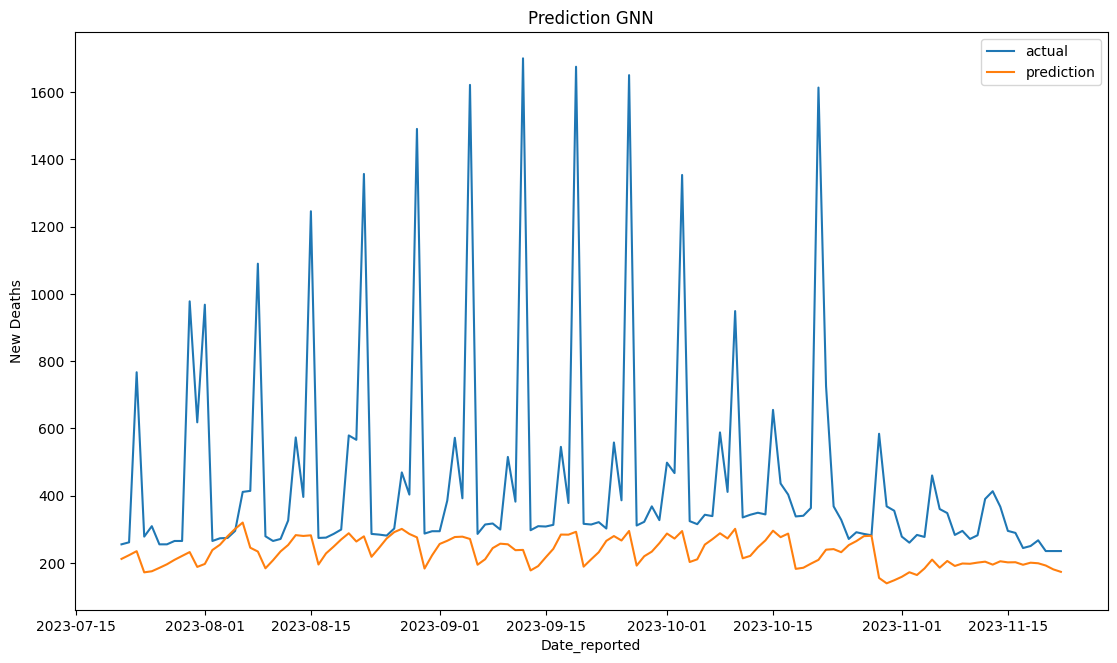

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(unique_dates[-len(pred):], y_true-1, label="actual")
ax.plot(unique_dates[-len(pred):], pred-1, label="prediction")
ax.set_title("Prediction GNN")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [14]:
print_evaluation_metrics(pred-1, y_true-1, np.sum(y_train, axis=1)-1)

Evaluation Metrics:
MSE: 156240.89
RMSE: 395.27
MAE: 225.53
MAPE: 36.73
SMAPE: 49.59
MASE: 0.12


In [15]:
len(unique_dates[-len(pred):])

125

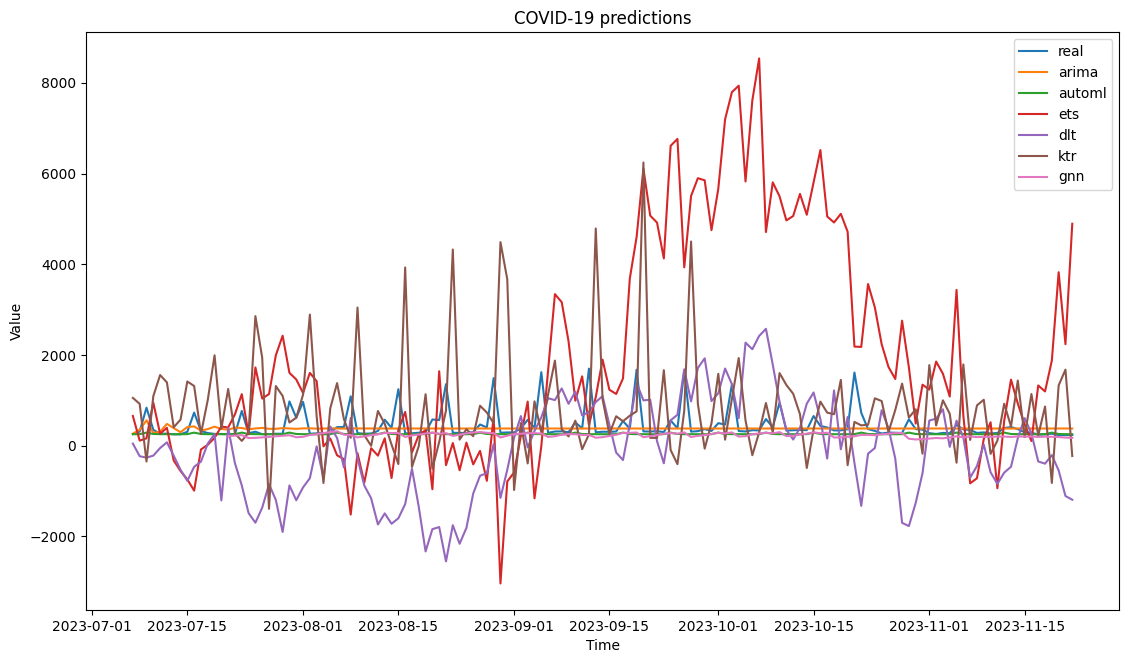

In [16]:
store_predictions_and_create_graph("gnn", unique_dates[-len(pred):], pred-1, y_true-1, "COVID-19")